In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
%matplotlib widget

In [3]:
FORCES = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF = [400, 450, 500, 550]

plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 2

line_styles = {"LO": {"marker": "d", "markevery": 10, "markersize": 3, "color": "tab:cyan"},
               "NLO": {"marker": ".", "markevery": 10, "color": "orange"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "green"},
               "N3LO": {"ls": "dotted", "color": "blue"},
               "N4LO": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "red"},
               "N4LO+": {"color": "black"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "blueviolet"},
               "SIEGERT": {"color": "blue"},
               "1NC": {"color": "deeppink", "ls": "dashed"}
               }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"],
             }

trunc_colors = {
    "NLO": "bisque",
    "N2LO": "limegreen",
    "N3LO": "dodgerblue",
    "N4LO": "red",
    "N4LO+": "black",
}

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}


In [30]:
src_incl = "He_photodis/incl_10pp40/"
src = "He_photodis/HE_2NF/"
forces = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]

## ppn

### Exclusive

In [17]:
files = [file for file in os.listdir(src) if "incl" not in file and file.startswith("ppn")] 

In [6]:
# fname = files40[0]
def read_data(fname):
    df = pd.read_csv(src + fname, skiprows=1, skipinitialspace=True, sep=" ")
    df["Energy"] = float(fname.split("-")[2])
    df["FORCE"] = fname.split("-")[3].split("_")[-1]
    df["CUTOFF"] = int(fname.split("-")[1][-3:])
    return df

In [18]:
df1 = pd.concat([read_data(fname) for fname in files], ignore_index=True)

In [22]:
df1.sort_values("SLANGE", inplace=True)

In [24]:
# df1.to_csv("HE_pnn_excl.csv", index=False)

In [4]:
df1 = pd.read_csv("HE_pnn_excl.csv")

In [8]:
df1.head()

,I,SLANGE,CROSS,E1,E2,E3,Energy,FORCE,CUTOFF
0,1,0.5,3.562000e-08,60.368,0.009,31.905,100.0,N3LO,450
1,1,0.5,3.416000e-08,60.368,0.009,31.905,100.0,N3LO,400
2,1,0.5,2.725000e-08,60.368,0.009,31.905,100.0,NLO,400
3,1,0.5,3.580000e-08,60.368,0.009,31.905,100.0,N4LO+,500
4,1,0.5,2.912000e-07,12.845,0.030,9.407,30.0,N4LO,400


#### Truncation

In [16]:
from truncation import get_truncation


/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


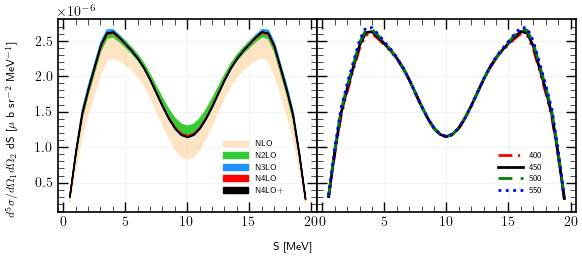

In [35]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=30

df_tmp = df1[(df1.CUTOFF == 450) &
             (df1.Energy == en)]
df_tmp.sort_values("SLANGE", inplace=True)
df_piv = df_tmp.pivot(index="SLANGE", columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
# fig.suptitle(f"Exclusive at energy 120[MeV]")
# fig.supylabel("d\sigma", x=0.03, y=0.6, size=12)
fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [$\mu$ b sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES[1:]:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                   & (df1["FORCE"] == force) ]
    # axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.SLANGE, df_tmp["CROSS"].values+df_trunc[force].values,
                            df_tmp["CROSS"].values-df_trunc[force].values, label=force,
                            color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                   & (df1["FORCE"] == "N4LO+") ]
    axes[1].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    # ax.set_xticks(np.arange(0, 180+j-1, 30))
    # ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3, loc="lower right", bbox_to_anchor=(0.4, 0.05, 0.5, 0.5))
plt.tight_layout()

plt.savefig(f"Figures_HE/CROSS_excl_trunc_{en}mev.pdf", dpi=600, facecolor="white")


/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


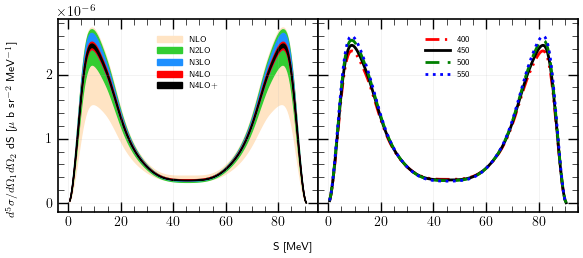

In [39]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=100

df_tmp = df1[(df1.CUTOFF == 450) &
             (df1.Energy == en)]
df_tmp.sort_values("SLANGE", inplace=True)
df_piv = df_tmp.pivot(index="SLANGE", columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
# fig.suptitle(f"Exclusive at energy 120[MeV]")
# fig.supylabel("d\sigma", x=0.03, y=0.6, size=12)
fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [$\mu$ b sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES[1:]:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                   & (df1["FORCE"] == force) ]
    # axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.SLANGE, df_tmp["CROSS"].values+df_trunc[force].values,
                            df_tmp["CROSS"].values-df_trunc[force].values, label=force,
                            color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                   & (df1["FORCE"] == "N4LO+") ]
    axes[1].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    # ax.set_xticks(np.arange(0, 180+j-1, 30))
    # ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3, loc="upper center", bbox_to_anchor=(0., 0.45, 1., 0.5))
plt.tight_layout()

plt.savefig(f"Figures_HE/CROSS_excl_trunc_{en}mev.pdf", dpi=600, facecolor="white")


#### ORDER

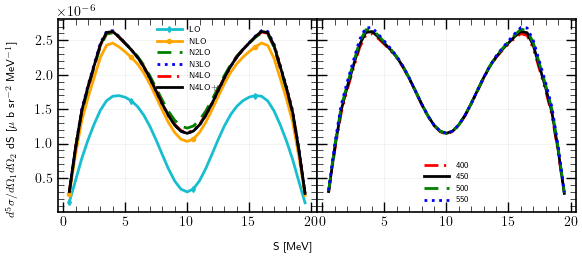

In [10]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=30
fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
# fig.suptitle(f"Exclusive at energy 120[MeV]")
# fig.supylabel("d\sigma", x=0.03, y=0.6, size=12)
fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [$\mu$ b sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                   & (df1["FORCE"] == force) ]
    axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                   & (df1["FORCE"] == "N4LO+") ]
    axes[1].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    # ax.set_xticks(np.arange(0, 180+j-1, 30))
    # ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3)
plt.tight_layout()

# plt.savefig(f"Figures_HE/CROSS_excl_{en}mev.pdf", dpi=300, facecolor="white")

### Inclusive

In [31]:
files_inc = [file for file in os.listdir(src)
             if "incl" in file and file.startswith("ppn")] 

In [32]:
files_inc2 = os.listdir(src_incl) 

In [33]:
def read_data_incl(fname, src=src):
    df = pd.read_csv(src + fname, skiprows=8, skipinitialspace=True, sep=" ")
    df["FORCE"] = fname.split("-")[3].split("_")[-1]
    try:
        df["CUTOFF"] = int(fname.split("-")[1][-3:])
        df["Energy"] = float(fname.split("-")[2])
    except:
        df["CUTOFF"] = int(fname.split("-")[2][-3:])
        df["Energy"] = float(fname.split("-")[1])
    if fname.split("-")[-2] == "incl":
        df["angle"] = int(fname.split("-")[-1][:-3])
    else:
        df["angle"] = int(fname.split("-")[-4][:-3])
    return df

In [34]:
df2 = pd.concat([read_data_incl(fname, src=src_incl) for fname in files_inc2], ignore_index=True)

In [35]:
df2.sort_values("E1", inplace=True)

In [36]:
df2.to_csv("HE_pnn_incl_new_angles_10pp40.csv", index=False)

In [ ]:
# df2 = pd.read_csv("HE_pnn_incl_new_angles_10pp40.csv")

In [37]:
df2.head()

,I,E1,CROSS,AX,AY,AZ,FORCE,CUTOFF,Energy,angle
15999,1,0.12,0.000033,-0.026604,5.628200e-17,-4.117600e-19,N4LO+,450,100.0,90
11599,1,0.12,0.000213,-0.001438,5.381400e-17,2.850700e-17,N4LO,500,30.0,170
11399,1,0.12,0.000014,-0.000166,4.224400e-17,-3.102500e-18,LO,450,100.0,10
11199,1,0.12,0.000030,-0.009019,5.948900e-17,2.915700e-18,N2LO,400,100.0,50
10999,1,0.12,0.000027,-0.013194,3.799200e-17,-8.095400e-18,NLO,450,100.0,130


In [38]:
import matplotlib.ticker

In [89]:
def create_subtitle(fig: plt.Figure, grid: mpl.gridspec.SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', y=0.88)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

/tmp/ipykernel_852420/2605013276.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


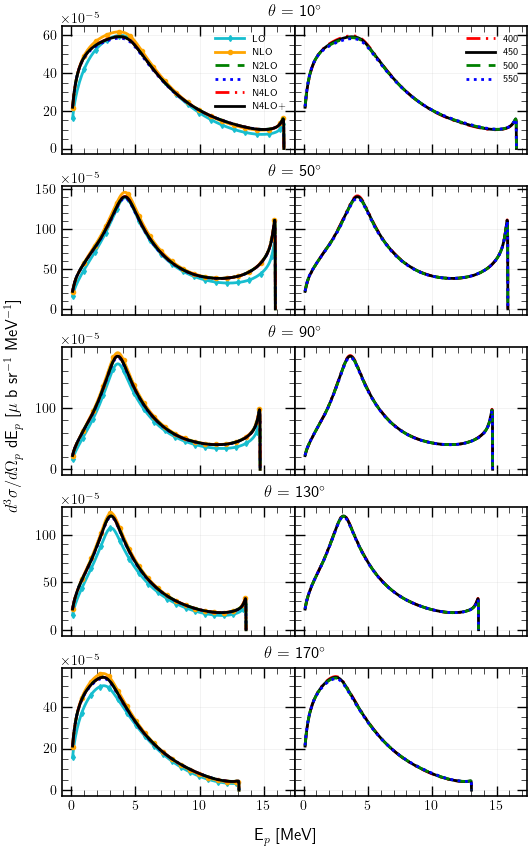

In [94]:
# for en in [30]:
en = 30
fig = plt.figure(figsize=(6, 10))
gs = fig.add_gridspec(ncols=2, nrows=5, wspace=0, hspace=0.25)
axes = gs.subplots(sharey="row", sharex="col")
obs = "CROSS"
fig.supylabel("$d^3\sigma/d\Omega _p$ dE$_p$ [$\mu$ b sr$^{-1}$ MeV$^{-1}$]", size=12, x=0.03)
fig.supxlabel("E$_p$ [MeV]", size=12, y=0.06)
for i, angle in enumerate(np.sort(df2["angle"].unique())):
    axes[i, 0].ticklabel_format(axis="y", style="sci", scilimits=(-5, -5))
    create_subtitle(fig, gs[i, 0:2], f"$\\theta$ = {angle}$^\circ$")
    for force in FORCES:
        df_tmp =  df2[(df2["CUTOFF"]==450) & (df2["Energy"] == en)
                        & (df2["FORCE"] == force) & (df2["angle"] == angle)]
        axes[i, 0].plot(df_tmp["E1"], df_tmp[obs], **line_styles[force], label=force)
    for cut in CUTOFF:
        df_tmp =  df2[(df2["CUTOFF"]==cut) & (df2["Energy"] == en)
                        & (df2["FORCE"] == "N4LO+") & (df2["angle"] == angle)]
        axes[i, 1].plot(df_tmp["E1"], df_tmp[obs], **ls_cutoff[cut], label=cut)
    for j, ax in enumerate(axes[i]):
        ax.tick_params(which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
        ax.tick_params(which='major', direction='in',
                    length=7, width=1, top=True, right=True, zorder=1)
        ax.grid(alpha=0.2)
        ax.set_zorder(-1)
axes[0,0].legend(fontsize=7, handlelength=3)
axes[0,1].legend(fontsize=7, handlelength=3)
plt.tight_layout()
plt.savefig(f"Figures_HE/{obs}_incl_{en}mev_all.pdf", dpi=300, facecolor="white")
    # plt.close()
plt.show()


## Nd

In [76]:
files = [file for file in os.listdir(src) if "incl" not in file and file.startswith("CrossHe")] 

In [85]:
# fname = files40[0]
def read_data_nd(fname):
    df = pd.read_csv(src + fname, skipinitialspace=True, sep=" ", names=["I", "angle", "CROSS", "CROSS2"])
    df["FORCE"] = fname.split("-")[2]
    df["Energy"] = float(fname.split("-")[3].split("_")[-1])
    df["CUTOFF"] = int(fname.split("-")[1][-3:])
    return df


In [86]:
df3 = pd.concat([read_data_nd(fname) for fname in files], ignore_index=True)

In [88]:
df3.sort_values("angle", inplace=True)

In [90]:
# df3.to_csv("HE_nd.csv", index=False)

In [91]:
df3.head()

,I,angle,CROSS,CROSS2,FORCE,Energy,CUTOFF
11764,181,0.0,0.005755,0.000064,N4LO+,120.0,500
3619,181,0.0,0.052880,0.000338,LO,40.0,400
4705,181,0.0,0.058020,0.000470,NLO,30.0,400
1266,181,0.0,0.053360,0.000540,N4LO,30.0,500
7239,181,0.0,0.005866,0.000065,N4LO,120.0,500


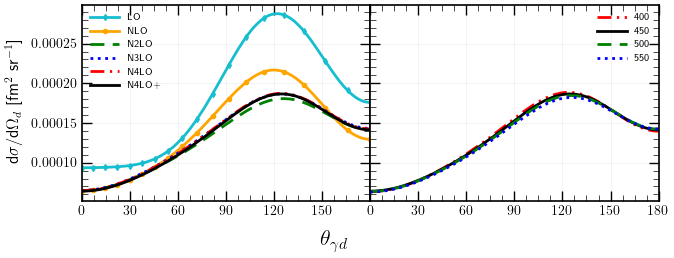

In [94]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en = 120
fig = plt.figure(figsize=(7, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
# fig.suptitle(f"Exclusive at energy 120[MeV]")
fig.supylabel("d$\sigma$/d$\Omega_d$ [fm$^2$ sr$^{-1}$]", x=0.03, y=0.6, size=12)
fig.supxlabel("$\\theta_{\gamma d}$", y=0.06, size=16)
# fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [sr$^{-1}$ fm$^{2}$]", size=8)

for force in FORCES:
    df_tmp =  df3[(df3["CUTOFF"]==450) & (df3["Energy"] == en)
                   & (df3["FORCE"] == force) ]
    axes[0].plot(df_tmp["angle"], df_tmp["CROSS2"], **line_styles[force], label=force)
for cut in CUTOFF:
    df_tmp =  df3[(df3["CUTOFF"]==cut) & (df3["Energy"] == en)
                   & (df3["FORCE"] == "N4LO+") ]
    axes[1].plot(df_tmp["angle"], df_tmp["CROSS2"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j, 30))
    ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
    ax.legend(fontsize=7, handlelength=3)
plt.tight_layout()
plt.savefig(f"Figures_HE/CROSS_nd_{en}mev.pdf", dpi=300, facecolor="white")